# CNN Factorio AI

In [1]:
import torch

print(torch.version.cuda)
# Check if CUDA GPU is available
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA not available. Training on CPU.")


12.4
CUDA is available. Training on GPU.


### Data processing

In [30]:
import numpy as np

import game
import importlib

importlib.reload(game)

from game import Board

import json
from tqdm import tqdm

#map_sym_int = json.load(open("sample.json", "r"))


def count_lines(filename):
    with open(filename, "rb") as f:  # binary mode for speed
        return sum(1 for _ in f)

filename = "game.txt"
total_lines = count_lines(filename)

# Parse the data
def parse_data(file):
    inputs = []
    outputs = []
    b = Board()

    index_board = ""
    with open(file,"r") as f:
        for line in tqdm(f, total=total_lines, desc="Parsing data"):
            if line == "\n":
                line = line.strip()
                #grid_array = str_to_array(index_board)
                grid_array = index_board.strip().split("\n")
                b.board_from_index(grid_array)
                r = b.total_reward()
                inputs.append(grid_array)
                outputs.append(float(r))
                b.board = b.reset()
                index_board = ""
            else:
                index_board += line
    return np.array(inputs), np.array(outputs).reshape(-1,1)

X, y = parse_data(filename)
print(X.shape, y.shape)
print(max(y), min(y))

Parsing data: 100%|██████████| 28080/28080 [00:00<00:00, 265137.18it/s]

(5616, 4) (5616, 1)
[13.] [0.]


In [31]:
import entities


importlib.reload(game)
importlib.reload(entities)
from game import Board

idx_x = np.where(y == min(y))[0][0]
b = Board()
b.board_from_index(X[idx_x])
print(idx_x)
print(b)
print(b.total_reward())

0
Co B> Co Co 
Co Co Co Co 
Co Co Co Co 
Co Co Co Co 

0


In [86]:
print(len(y[y > 0.0]), len(y[y < -2.0]))

977 34782


(array([1.908e+03, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.900e+01,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.800e+02,
        0.000e+00, 0.000e+00, 7.000e+00, 0.000e+00, 0.000e+00, 1.300e+01,
        0.000e+00, 1.000e+01, 1.000e+00, 0.000e+00, 3.000e+00, 9.730e+02,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.900e+01, 0.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 4.000e+00, 6.370e+02, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.700e+01, 0.000e+00,
        0.000e+00, 6.000e+00, 0.000e+00, 5.000e+00, 3.270e+02, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.300e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.670e+02, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.430e+02, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.500e+0

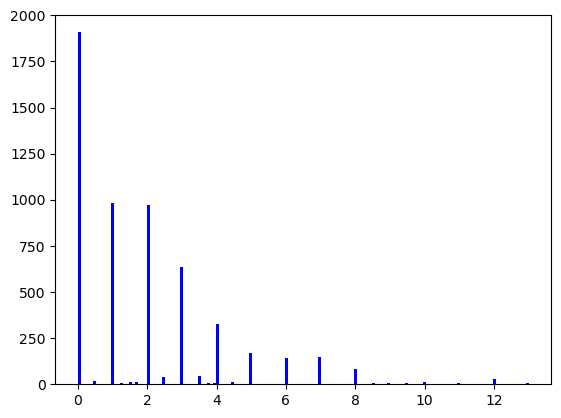

In [32]:
import matplotlib.pyplot as plt

plt.hist(y, bins=150, color='blue')

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from var import CELL_NUMBER

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_split = [list(map(int, x.split())) for x in X.flatten()]
X_split = np.array(X_split).reshape(X.shape[0], CELL_NUMBER, CELL_NUMBER)
print(X_split.shape)
X_flat = X_split.reshape((X.shape[0], -1))

X_train , X_test, y_train,y_test = train_test_split(X_flat, y,test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train_scaled = scaler_X.fit_transform(X_train).reshape(-1, CELL_NUMBER, CELL_NUMBER)
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled = scaler_X.transform(X_test).reshape(-1, CELL_NUMBER, CELL_NUMBER)
y_test_scaled = scaler_y.transform(y_test)

(5616, 4, 4)
(4492, 16) (4492, 1) (1124, 16) (1124, 1)


In [34]:
from torch.utils.data import Dataset, DataLoader

class GridRewardDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # shape: (N, 1, 5, 5)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoader
ds_train = GridRewardDataset(X_train_scaled, y_train_scaled)
ds_test = GridRewardDataset(X_test_scaled, y_test_scaled)

train = DataLoader(ds_train, batch_size=32, shuffle=True,num_workers=27)
test = DataLoader(ds_test, batch_size=32,num_workers=27)

### Lightning Module

In [35]:
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint


#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#os.environ['CUDA_LAUNCH_BLOCKING']='1'

class RewardCNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # (B, 32, 5, 5)
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B, 64, 5, 5)
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.AvgPool2d(kernel_size=2),                 # (B, 64, 2, 2)
    nn.Dropout(0.25),
    nn.Flatten(),                                # (B, 64*2*2)
    nn.Linear(64 * 2 * 2, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
        )
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss,on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",          # metric to monitor
    mode="min",                  # minimize val_loss
    save_top_k=1,                # save only the best
    filename="best-checkpoint", # optional name
    verbose=True
)


early_stop_callback = EarlyStopping(
    monitor="val_loss",         # What to monitor
    patience=5,                 # Stop after 3 epochs without improvement
    verbose=True,
    mode="min"                  # Minimize the loss
)

model = RewardCNN()
trainer = pl.Trainer(max_epochs=100, callbacks=[checkpoint_callback,early_stop_callback],log_every_n_steps=1)
trainer.fit(model, train,test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 52.0 K | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
52.0 K    Trainable params
0         Non-trainable params
52.0 K    Total params
0.208     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 141/141 [00:02<00:00, 70.41it/s, v_num=1, val_loss=0.0093, train_loss=0.0188]

Metric val_loss improved. New best score: 0.009
Epoch 0, global step 141: 'val_loss' reached 0.00930 (best 0.00930), saving model to '/home/matthieu/Documents/FactorioAI/GNN/lightning_logs/version_1/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 1: 100%|██████████| 141/141 [00:02<00:00, 50.66it/s, v_num=1, val_loss=0.00867, train_loss=0.00998]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.009
Epoch 1, global step 282: 'val_loss' reached 0.00867 (best 0.00867), saving model to '/home/matthieu/Documents/FactorioAI/GNN/lightning_logs/version_1/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 2: 100%|██████████| 141/141 [00:02<00:00, 52.68it/s, v_num=1, val_loss=0.006, train_loss=0.00834]  

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.006
Epoch 2, global step 423: 'val_loss' reached 0.00600 (best 0.00600), saving model to '/home/matthieu/Documents/FactorioAI/GNN/lightning_logs/version_1/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 3: 100%|██████████| 141/141 [00:02<00:00, 52.14it/s, v_num=1, val_loss=0.00559, train_loss=0.00705]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 3, global step 564: 'val_loss' reached 0.00559 (best 0.00559), saving model to '/home/matthieu/Documents/FactorioAI/GNN/lightning_logs/version_1/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 4: 100%|██████████| 141/141 [00:02<00:00, 51.40it/s, v_num=1, val_loss=0.00573, train_loss=0.00622]

Epoch 4, global step 705: 'val_loss' was not in top 1


Epoch 5: 100%|██████████| 141/141 [00:02<00:00, 52.51it/s, v_num=1, val_loss=0.00512, train_loss=0.00563]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 5, global step 846: 'val_loss' reached 0.00512 (best 0.00512), saving model to '/home/matthieu/Documents/FactorioAI/GNN/lightning_logs/version_1/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 6: 100%|██████████| 141/141 [00:02<00:00, 50.49it/s, v_num=1, val_loss=0.00396, train_loss=0.0052] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004
Epoch 6, global step 987: 'val_loss' reached 0.00396 (best 0.00396), saving model to '/home/matthieu/Documents/FactorioAI/GNN/lightning_logs/version_1/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 7: 100%|██████████| 141/141 [00:02<00:00, 50.59it/s, v_num=1, val_loss=0.00426, train_loss=0.00477]

Epoch 7, global step 1128: 'val_loss' was not in top 1


Epoch 8: 100%|██████████| 141/141 [00:02<00:00, 54.37it/s, v_num=1, val_loss=0.00466, train_loss=0.00482]

Epoch 8, global step 1269: 'val_loss' was not in top 1


Epoch 9: 100%|██████████| 141/141 [00:02<00:00, 53.01it/s, v_num=1, val_loss=0.00402, train_loss=0.00426]

Epoch 9, global step 1410: 'val_loss' was not in top 1


Epoch 10: 100%|██████████| 141/141 [00:02<00:00, 49.82it/s, v_num=1, val_loss=0.00367, train_loss=0.00403]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
Epoch 10, global step 1551: 'val_loss' reached 0.00367 (best 0.00367), saving model to '/home/matthieu/Documents/FactorioAI/GNN/lightning_logs/version_1/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 11: 100%|██████████| 141/141 [00:02<00:00, 51.10it/s, v_num=1, val_loss=0.00329, train_loss=0.00353]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 11, global step 1692: 'val_loss' reached 0.00329 (best 0.00329), saving model to '/home/matthieu/Documents/FactorioAI/GNN/lightning_logs/version_1/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 12: 100%|██████████| 141/141 [00:02<00:00, 51.71it/s, v_num=1, val_loss=0.00333, train_loss=0.00335]

Epoch 12, global step 1833: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 141/141 [00:02<00:00, 50.95it/s, v_num=1, val_loss=0.00353, train_loss=0.00331]

Epoch 13, global step 1974: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 141/141 [00:02<00:00, 51.44it/s, v_num=1, val_loss=0.00301, train_loss=0.00306]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 14, global step 2115: 'val_loss' reached 0.00301 (best 0.00301), saving model to '/home/matthieu/Documents/FactorioAI/GNN/lightning_logs/version_1/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 15: 100%|██████████| 141/141 [00:02<00:00, 50.66it/s, v_num=1, val_loss=0.00317, train_loss=0.00333]

Epoch 15, global step 2256: 'val_loss' was not in top 1


Epoch 16: 100%|██████████| 141/141 [00:02<00:00, 52.30it/s, v_num=1, val_loss=0.00266, train_loss=0.00282]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 16, global step 2397: 'val_loss' reached 0.00266 (best 0.00266), saving model to '/home/matthieu/Documents/FactorioAI/GNN/lightning_logs/version_1/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 17: 100%|██████████| 141/141 [00:02<00:00, 50.48it/s, v_num=1, val_loss=0.00256, train_loss=0.00279]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 17, global step 2538: 'val_loss' reached 0.00256 (best 0.00256), saving model to '/home/matthieu/Documents/FactorioAI/GNN/lightning_logs/version_1/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 18: 100%|██████████| 141/141 [00:02<00:00, 51.02it/s, v_num=1, val_loss=0.00276, train_loss=0.00275]

Epoch 18, global step 2679: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 141/141 [00:02<00:00, 50.23it/s, v_num=1, val_loss=0.00318, train_loss=0.00254]

Epoch 19, global step 2820: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 141/141 [00:02<00:00, 51.87it/s, v_num=1, val_loss=0.00222, train_loss=0.0025] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
Epoch 20, global step 2961: 'val_loss' reached 0.00222 (best 0.00222), saving model to '/home/matthieu/Documents/FactorioAI/GNN/lightning_logs/version_1/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 21: 100%|██████████| 141/141 [00:02<00:00, 51.06it/s, v_num=1, val_loss=0.0024, train_loss=0.00253]

Epoch 21, global step 3102: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 141/141 [00:02<00:00, 49.94it/s, v_num=1, val_loss=0.00231, train_loss=0.00238]

Epoch 22, global step 3243: 'val_loss' was not in top 1


Epoch 23: 100%|██████████| 141/141 [00:02<00:00, 51.27it/s, v_num=1, val_loss=0.003, train_loss=0.00226]  

Epoch 23, global step 3384: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 141/141 [00:02<00:00, 51.83it/s, v_num=1, val_loss=0.00219, train_loss=0.00245]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
Epoch 24, global step 3525: 'val_loss' reached 0.00219 (best 0.00219), saving model to '/home/matthieu/Documents/FactorioAI/GNN/lightning_logs/version_1/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 25: 100%|██████████| 141/141 [00:02<00:00, 50.43it/s, v_num=1, val_loss=0.00247, train_loss=0.00231]

Epoch 25, global step 3666: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 141/141 [00:02<00:00, 49.77it/s, v_num=1, val_loss=0.00207, train_loss=0.00212]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
Epoch 26, global step 3807: 'val_loss' reached 0.00207 (best 0.00207), saving model to '/home/matthieu/Documents/FactorioAI/GNN/lightning_logs/version_1/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 27: 100%|██████████| 141/141 [00:02<00:00, 51.23it/s, v_num=1, val_loss=0.00254, train_loss=0.00211]

Epoch 27, global step 3948: 'val_loss' was not in top 1


Epoch 28: 100%|██████████| 141/141 [00:02<00:00, 52.58it/s, v_num=1, val_loss=0.00213, train_loss=0.002]  

Epoch 28, global step 4089: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 141/141 [00:02<00:00, 51.10it/s, v_num=1, val_loss=0.00196, train_loss=0.00201]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
Epoch 29, global step 4230: 'val_loss' reached 0.00196 (best 0.00196), saving model to '/home/matthieu/Documents/FactorioAI/GNN/lightning_logs/version_1/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 30: 100%|██████████| 141/141 [00:02<00:00, 51.71it/s, v_num=1, val_loss=0.00187, train_loss=0.00205]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
Epoch 30, global step 4371: 'val_loss' reached 0.00187 (best 0.00187), saving model to '/home/matthieu/Documents/FactorioAI/GNN/lightning_logs/version_1/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 31: 100%|██████████| 141/141 [00:02<00:00, 49.26it/s, v_num=1, val_loss=0.00233, train_loss=0.00179]

Epoch 31, global step 4512: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 141/141 [00:02<00:00, 52.18it/s, v_num=1, val_loss=0.00206, train_loss=0.00172]

Epoch 32, global step 4653: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 141/141 [00:02<00:00, 51.75it/s, v_num=1, val_loss=0.00199, train_loss=0.00199]

Epoch 33, global step 4794: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 141/141 [00:02<00:00, 51.24it/s, v_num=1, val_loss=0.00193, train_loss=0.00166]

Epoch 34, global step 4935: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 141/141 [00:02<00:00, 52.06it/s, v_num=1, val_loss=0.00202, train_loss=0.00176]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.002. Signaling Trainer to stop.
Epoch 35, global step 5076: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 141/141 [00:02<00:00, 51.99it/s, v_num=1, val_loss=0.00202, train_loss=0.00176]


Mean error: 0.35771424
Max error: 4.8012843
Min error: 0.00071048737
Std error: 0.46146357
Median error: 0.21815129
Std/mean error: 129.00342


(array([333., 186., 130., 110.,  85.,  67.,  52.,  46.,  24.,  18.,  19.,
          8.,   5.,   4.,   7.,   6.,   2.,   3.,   2.,   3.,   2.,   0.,
          0.,   1.,   1.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   1.]),
 array([7.10487366e-04, 9.67219621e-02, 1.92733437e-01, 2.88744926e-01,
        3.84756386e-01, 4.80767846e-01, 5.76779366e-01, 6.72790825e-01,
        7.68802285e-01, 8.64813745e-01, 9.60825205e-01, 1.05683672e+00,
        1.15284824e+00, 1.24885964e+00, 1.34487116e+00, 1.44088256e+00,
        1.53689408e+00, 1.63290560e+00, 1.72891700e+00, 1.82492852e+00,
        1.92093992e+00, 2.01695156e+00, 2.11296296e+00, 2.20897436e+00,
        2.30498600e+00, 2.40099740e+00, 2.49700880e+00, 2.59302020e+00,
        2.68903184e+00, 2.78504324e+00, 2.88105464e+00, 2.97706628e+00,
        3.07307768e+00, 3.16908908e+00, 3.26510072e+00, 3.36111212e+00,
        3.

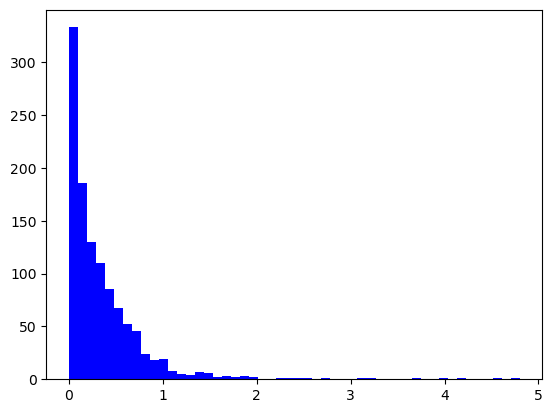

In [37]:
model.eval()
error = []
with torch.no_grad():
    for i, (x, y_true) in enumerate(test):
        y_pred = model(x)
        y_pred_denorm = scaler_y.inverse_transform(y_pred.cpu().numpy())
        y_true_denorm = scaler_y.inverse_transform(y_true.cpu().numpy())
        for yt, yp in zip(y_true_denorm, y_pred_denorm):
            error.append(np.abs(yp - yt)[0])

#print(error)
print("Mean error:", np.mean(error))
print("Max error:", np.max(error))
print("Min error:", np.min(error))
print("Std error:", np.std(error))
print("Median error:", np.median(error))
print("Std/mean error:", np.std(error) / np.mean(error) * 100)
plt.hist(error, bins=50, color='blue')